<a href="https://colab.research.google.com/github/mariba66/mariba66/blob/main/songsrecomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install kaggle -q


In [6]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [7]:
kaggle_config =json.load(open("kaggle.json"))


In [8]:
kaggle_config.keys()


dict_keys(['username', 'key'])

In [9]:
os.environ["KAGGLE_USERNAME"] = kaggle_config["username"]
os.environ["KAGGLE_KEY"] = kaggle_config["key"]

In [10]:
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
  0% 0.00/20.7M [00:00<?, ?B/s]
100% 20.7M/20.7M [00:00<00:00, 1.16GB/s]


In [11]:
!ls



drive  kaggle.json  sample_data  spotify-million-song-dataset.zip


In [12]:
with zipfile.ZipFile("spotify-million-song-dataset.zip", "r") as zip_ref:
    zip_ref.extractall()


In [13]:
df=pd.read_csv("/content/spotify_millsongdata.csv")

In [14]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [15]:
df.shape


(57650, 4)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [17]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [18]:
top_artists=df['artist'].value_counts().head(1)
print('Top ten artists:')
print(top_artists)

Top ten artists:
artist
Donna Summer    191
Name: count, dtype: int64


In [19]:
df=df.sample(20000)
df = df.drop('link', axis=1).reset_index(drop=True)

In [20]:
df.shape


(20000, 3)

In [21]:
df.head(3)

,artist,song,text
0,David Bowie,Kingdom Come,Well I walked in the pouring rain \r\nAnd I h...
1,Uriah Heep,Pacific Highway,Tryin' to make it back \r\nTo my old home tow...
2,Hillsong,Deeper,"Light of men, love of God \r\nHealing for the..."


In [22]:
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

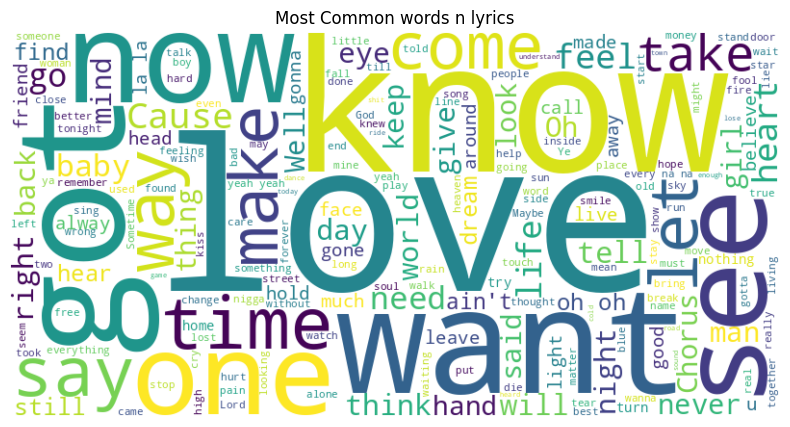

In [23]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Most Common words n lyrics")
plt.show()

Data Preprocessing


In [24]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
stop_words=set(stopwords.words('english'))

In [26]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

In [27]:
#apply preprocessing to lyrics
df['cleaned_text']=df['text'].apply(preprocess_text)

In [28]:
tfidf_vectorize = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorize.fit_transform(df["cleaned_text"])


In [29]:
#compute cosine similarity
cosine_sim=cosine_similarity(tfidf_matrix,tfidf_matrix)

In [30]:
 # Recommendation function
def recommend_songs(song_name, cosine_sim, df=df, top_n=5):  # 🛠 FIXED: top_n-s → top_n=5
    # Find the index of the song
    idx = df[df["song"].str.lower() == song_name.lower()].index

    if len(idx) == 0:
        return "Song not found in the dataset!"

    idx = idx[0]  # 🛠 FIXED: idx[o] → idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))  # 💡 cosine similarity scores for the song

    # Sort by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top n most similar songs (excluding the song itself)
    sim_scores = sim_scores[1:top_n+1]

    # Get indices of recommended songs
    song_indices = [i[0] for i in sim_scores]

    # Return artist and song name of recommended songs
    return df[["artist", "song"]].iloc[song_indices]


In [37]:
df["song"][5]

'God Gave Me A Heart To Forgive'

In [40]:
recommendations = recommend_songs("My little One", cosine_sim)
print(recommendations)


                     artist              song
8405          Cliff Richard  A Little In Love
13951                 Bread  Never Let Her Go
18866  Alan Parsons Project       Little Hans
2475             John Prine         Only Love
4083                  Annie      Little Girls


In [41]:
!git config --global user.name "mariba66"


In [42]:
!git clone https://github.com/mariba66/mldocumentation/song-recommendation-project.git

Cloning into 'song-recommendation-project'...
remote: Not Found
fatal: repository 'https://github.com/mariba66/mldocumentation/song-recommendation-project.git/' not found
